# Introduction

In this notebook I will explore three different models for segmentation on this CamVid Dataset which has 32 classes. The models that I explored here are-
   
   - **Fully Convolutional Network model :** This model is proposed by [1](https://arxiv.org/pdf/1411.4038). Moreover, I also have insights from [here] (https://github.com/khalequzzamanlikhon/DeepLearning-ComputerVision/blob/master/08-Segmentation-Detection/01-Semantic-Segmentation.ipynb). Inspired by these I have defined a FCN using resnet50 as backbone followed by custom decoders.
   
   - **U-net architecture with attention mechanism :** I have defined a unet architecture with attentin mechanism
   
   - **Deeplabv3+ model :** Inspired by [2](https://arxiv.org/pdf/1802.02611), I have applied deeplabv3+ model here on this dataset.
   
   
Applying and comparing these models, I struggled to get a good mIoU. Even with the deeplabv3+. So my request to you, if you have come across this notebook and find anything that might improve the model's performance regarding mIoU please leave a message [here](https://www.linkedin.com/in/khalequzzaman-likhon/) mentioning this notebook. You can also find this notebook at [github](https://github.com/khalequzzamanlikhon/Image-Segmentation-CamVid)

# Loading libraries

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import resnet18
from torchvision.models import resnet50
import torchvision.models.segmentation as segmentation
from torchviz import make_dot
from torch.autograd import Variable
from sklearn.metrics import jaccard_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Setting device

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# ---------- GPU Settings ----------
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


# Data preparation

In [4]:
import pandas as pd

def load_color_mapping(csv_path):
    # Load the CSV file
    df = pd.read_csv(csv_path)
    # Create a mapping from (r, g, b) to the class index
    color_mapping = {(row['r'], row['g'], row['b']): idx for idx, row in df.iterrows()}
    return color_mapping,df


In [5]:
color_mapping,df=load_color_mapping("input/camvid/CamVid/class_dict.csv")
print(color_mapping)

{(64, 128, 64): 0, (192, 0, 128): 1, (0, 128, 192): 2, (0, 128, 64): 3, (128, 0, 0): 4, (64, 0, 128): 5, (64, 0, 192): 6, (192, 128, 64): 7, (192, 192, 128): 8, (64, 64, 128): 9, (128, 0, 192): 10, (192, 0, 64): 11, (128, 128, 64): 12, (192, 0, 192): 13, (128, 64, 64): 14, (64, 192, 128): 15, (64, 64, 0): 16, (128, 64, 128): 17, (128, 128, 192): 18, (0, 0, 192): 19, (192, 128, 128): 20, (128, 128, 128): 21, (64, 128, 192): 22, (0, 0, 64): 23, (0, 64, 64): 24, (192, 64, 128): 25, (128, 128, 0): 26, (192, 128, 192): 27, (64, 0, 64): 28, (192, 192, 0): 29, (0, 0, 0): 30, (64, 192, 0): 31}


## Custom Dataset class

In [6]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, color_mapping, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.color_mapping = color_mapping
        self.transform = transform
        self.image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')])
        self.label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and label
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        label = cv2.imread(self.label_files[idx]) # Load as RGB
        label=cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
        #Convert the RGB label to class indices
        label = self.convert_rgb_to_class(label)
#         Apply transformations, if any
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        return image, label.long()

    def convert_rgb_to_class(self, label):
        """Convert RGB mask to class indices."""
        # Create an empty mask with the same shape as the label
        class_mask = np.zeros((label.shape[0], label.shape[1]), dtype=int)

        # Iterate over each pixel and assign the class index based on RGB value
        for rgb, class_idx in self.color_mapping.items():
            mask = (label[:, :, 0] == rgb[0]) & (label[:, :, 1] == rgb[1]) & (label[:, :, 2] == rgb[2])
            class_mask[mask] = class_idx

        return class_mask


## Data augmentation

In [7]:
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(400, 520),
            A.RandomCrop(height=352, width=480),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.GaussianBlur(blur_limit=(3, 5), p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            A.Normalize(mean=(0.390, 0.405, 0.414), std=(0.274, 0.285, 0.297)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(352, 480),
            A.Normalize(mean=(0.390, 0.405, 0.414), std=(0.274, 0.285, 0.297)),
            ToTensorV2()
        ])


In [8]:
# Instantiate datasets with the color map
train_dataset = CamVidDataset('input/camvid/CamVid/train', 'input/camvid/CamVid/train_labels', color_mapping, transform=get_transforms(train=True))
val_dataset = CamVidDataset('input/camvid/CamVid/val', 'input/camvid/CamVid/val_labels', color_mapping, transform=get_transforms(train=False))
test_dataset = CamVidDataset('input/camvid/CamVid/test', 'input/camvid/CamVid/test_labels', color_mapping, transform=get_transforms(train=False))

## visualizing few input and label images

In [9]:
import matplotlib.pyplot as plt


def visualize_samples(dataset, color_mapping, num_samples=3):
    # Create a reverse mapping from class index to RGB values for visualization
    reverse_color_mapping = {v: k for k, v in color_mapping.items()}

    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))

    for i in range(num_samples):
        # Get a sample from the dataset
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
        label = label.numpy()


        # Create an RGB mask for visualization
        label_rgb = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
        for class_idx, rgb in reverse_color_mapping.items():
            label_rgb[label == class_idx] = rgb

        # Plot the image and label
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f'Sample {i + 1} - Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(label_rgb)
        axs[i, 1].set_title(f'Sample {i + 1} - Label')
        axs[i, 1].axis('off')


    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4210527..2.2262776].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2834538..1.4247891].


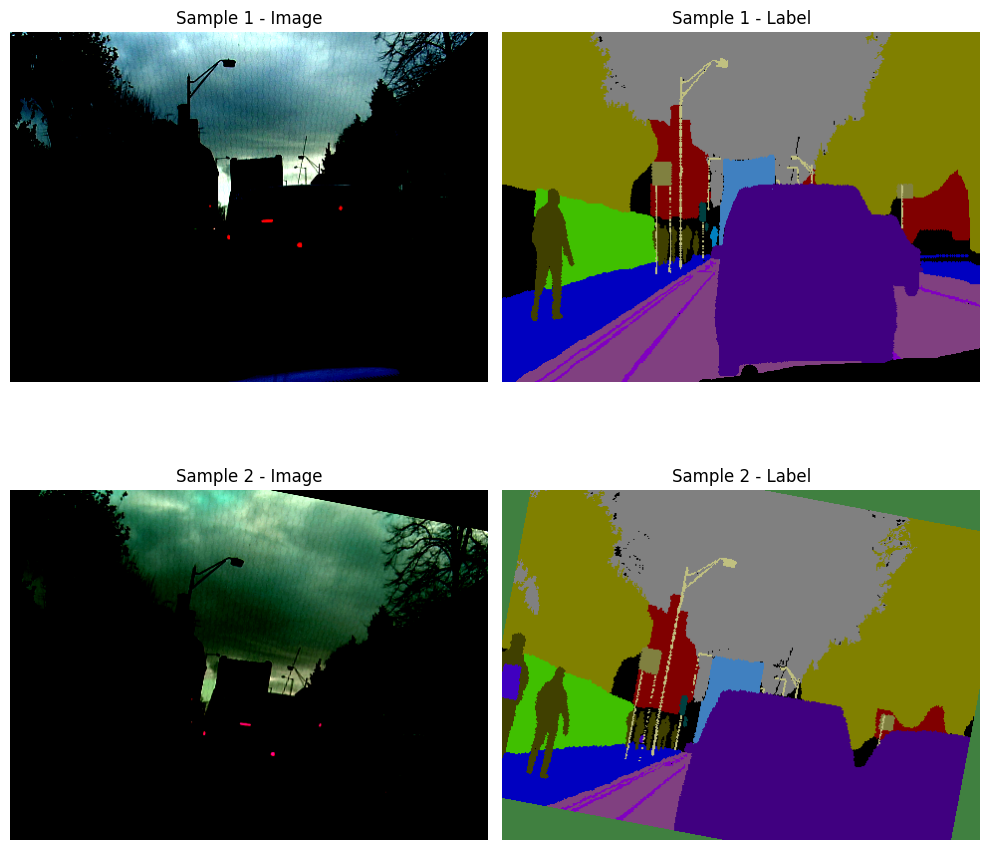

In [10]:
visualize_samples(train_dataset,color_mapping, num_samples=2)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Implementing the Fully Convolutional Network (FCN) -- Scratch

In [12]:
class FCNSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(FCNSegmentation, self).__init__()

        # ResNet-50 as encoder backbone
        resnet = models.resnet50(pretrained=True)

        # Encoder using ResNet50 layers, excluding the fully connected part
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Decoder for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(128, num_classes, kernel_size=4, stride=2, padding=1),
            nn.Upsample(size=(352, 480), mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




# U-net Using efficientnet


In [13]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNetResNet50(nn.Module):
    def __init__(self, num_classes):
        super(UNetResNet50, self).__init__()

        # Pre-trained ResNet-50 backbone
        resnet = resnet50(weights='IMAGENET1K_V1')

        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.encoder2 = nn.Sequential(resnet.maxpool, resnet.layer1)
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        # Decoder with attention
        self.attention5 = AttentionBlock(F_g=2048, F_l=1024, F_int=512)
        self.decoder5 = nn.Sequential(
            nn.Conv2d(2048 + 1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        self.attention4 = AttentionBlock(F_g=1024, F_l=512, F_int=256)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.attention3 = AttentionBlock(F_g=512, F_l=256, F_int=128)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.attention2 = AttentionBlock(F_g=256, F_l=64, F_int=32)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256 + 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Final output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)  # (B, 64, H/2, W/2)
        e2 = self.encoder2(e1) # (B, 256, H/4, W/4)
        e3 = self.encoder3(e2) # (B, 512, H/8, W/8)
        e4 = self.encoder4(e3) # (B, 1024, H/16, W/16)
        e5 = self.encoder5(e4) # (B, 2048, H/32, W/32)

        # Decoder with attention
        d5 = F.interpolate(e5, size=e4.size()[2:], mode='bilinear', align_corners=True)
        e4_att = self.attention5(d5, e4)
        d5 = torch.cat((d5, e4_att), dim=1)
        d5 = self.decoder5(d5)

        d4 = F.interpolate(d5, size=e3.size()[2:], mode='bilinear', align_corners=True)
        e3_att = self.attention4(d4, e3)
        d4 = torch.cat((d4, e3_att), dim=1)
        d4 = self.decoder4(d4)

        d3 = F.interpolate(d4, size=e2.size()[2:], mode='bilinear', align_corners=True)
        e2_att = self.attention3(d3, e2)
        d3 = torch.cat((d3, e2_att), dim=1)
        d3 = self.decoder3(d3)

        d2 = F.interpolate(d3, size=e1.size()[2:], mode='bilinear', align_corners=True)
        e1_att = self.attention2(d2, e1)
        d2 = torch.cat((d2, e1_att), dim=1)
        d2 = self.decoder2(d2)

        # Final output
        output = self.final_conv(d2)
        output = F.interpolate(output, size=(352,480), mode='bilinear', align_corners=True)

        return output


## Deeplabv3

In [14]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()
        # Load the pre-trained DeepLabV3+ model
        self.model = segmentation.deeplabv3_resnet50(pretrained=True)

        # Modify the classifier to output num_classes
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))

    def forward(self, x):
        # Forward pass
        return self.model(x)['out']


# Visualize model architecture

# Training 

## callbacks(early stopping)

In [15]:
import torch.optim as optim
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None or val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# loss function combined (dice + jaccard )

In [16]:
# dice loss

def dice_loss(pred, target, smooth=1e-6):
    # Convert target to one-hot encoding
    # target shape: (batch_size, height, width) -> (batch_size, num_classes, height, width)
    target = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

    pred = pred.contiguous()
    target = target.contiguous()

    # Compute Dice loss
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) /
                (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))

    # Average loss across all classes
    return loss.mean()

# Jaccard Loss

class JaccardLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Convert y_true to one-hot encoding (assumed input as (batch_size, height, width))
        y_true = F.one_hot(y_true, num_classes=y_pred.shape[1]).permute(0, 3, 1, 2).float()

        # Apply sigmoid to y_pred for binary/multiclass segmentation if necessary
        y_pred = torch.sigmoid(y_pred)

        # Flatten the tensors
        y_pred = y_pred.contiguous().view(y_pred.shape[0], -1)
        y_true = y_true.contiguous().view(y_true.shape[0], -1)

        # Compute intersection and union
        intersection = (y_pred * y_true).sum(dim=1)
        union = y_pred.sum(dim=1) + y_true.sum(dim=1) - intersection

        # Compute Jaccard Index (IoU)
        iou = (intersection + self.smooth) / (union + self.smooth)

        # Return Jaccard loss (1 - IoU)
        return 1 - iou.mean()



# Combined Loss (dice + jaccard)
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, jaccard_weight=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.jaccard_weight = jaccard_weight
        self.dice_loss = dice_loss
        self.jaccard_loss = JaccardLoss(smooth=smooth)

    def forward(self, y_pred, y_true):
        dice = self.dice_loss(y_pred, y_true)
        jaccard = self.jaccard_loss(y_pred, y_true)
        return self.dice_weight * dice + self.jaccard_weight * jaccard


combined_loss = CombinedLoss(dice_weight=0.7, jaccard_weight=0.3)


## Training setup

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Models
model_fcn = FCNSegmentation(num_classes=32).to(device)
model_unet = UNetResNet50(num_classes=32).to(device)
model_deeplab = DeepLabV3Plus(num_classes=32)

# Convert BatchNorm to GroupNorm
def convert_bn_to_gn(module):
    """Recursively replace all BatchNorm2d layers with GroupNorm."""
    for child_name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            setattr(module, child_name, nn.GroupNorm(num_groups=32, num_channels=child.num_features))
        else:
            convert_bn_to_gn(child)

convert_bn_to_gn(model_deeplab)
model_deeplab.to(device)

# Loss function
criterion = combined_loss

# Early Stopping
early_stopping1 = EarlyStopping(patience=7, delta=0.001)
early_stopping2 = EarlyStopping(patience=7, delta=0.001)
early_stopping3 = EarlyStopping(patience=7, delta=0.001)

# Optimizers
optimizer_fcn = optim.Adam(model_fcn.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer_unet = optim.Adam(model_unet.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_deeplab = optim.Adam(model_deeplab.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning Rate Schedulers (Remove verbose for compatibility)
scheduler_fcn = ReduceLROnPlateau(optimizer_fcn, mode='min', factor=0.1, patience=5)
scheduler_unet = ReduceLROnPlateau(optimizer_unet, mode='min', factor=0.1, patience=3)
scheduler_deeplab = ReduceLROnPlateau(optimizer_deeplab, mode='min', factor=0.1, patience=3)


c:\Users\DANIEL\anaconda3\envs\vt_kernel\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DANIEL\anaconda3\envs\vt_kernel\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\DANIEL\anaconda3\envs\vt_kernel\lib\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(
c:\Users\DANIEL\anaconda3\envs\vt_kernel\lib\site-packages\

# Saving model architecture as image

In [18]:
# # few images from trainloader
# batch = next(iter(train_loader))  # Get the first batch
# images, labels = batch
# images = images.to(device)

# # Pass the batch through the models
# y1 = model_fcn(images)
# y2 = model_unet(images)
# y3 = model_deeplab(images)

# make_dot(y1, params=dict(list(model_fcn.named_parameters()))).render("fcn_architecture", format="png")
# make_dot(y2, params=dict(list(model_unet.named_parameters()))).render("Unet_architecture", format="png")
# make_dot(y3, params=dict(list(model_deeplab.named_parameters()))).render("deeplab_architecture", format="png")


In [19]:
def training_loop(model,optimizer,scheduler,early_stopping):

    model.to(device)
    num_epochs = 100
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train_pixels = 0
        total_train_pixels = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Apply softmax to get probabilities for multi-class segmentation
            outputs = torch.softmax(outputs, dim=1)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Compute train accuracy (for each pixel)
            predicted_masks = torch.argmax(outputs, dim=1)
            correct_train_pixels += (predicted_masks == masks).sum().item()
            total_train_pixels += torch.numel(masks)

        # Calculate training accuracy
        train_acc = correct_train_pixels / total_train_pixels
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        correct_val_pixels = 0
        total_val_pixels = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = torch.softmax(outputs, dim=1)

                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Compute validation accuracy (for each pixel)
                predicted_masks = torch.argmax(outputs, dim=1)
                correct_val_pixels += (predicted_masks == masks).sum().item()
                total_val_pixels += torch.numel(masks)
        #clear gpu memeory after each training
        torch.cuda.empty_cache()

        # Calculate validation accuracy
        val_acc = correct_val_pixels / total_val_pixels
        val_accuracies.append(val_acc)

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping
        early_stopping(val_loss)
        if hasattr(early_stopping, 'early_stop') and early_stopping.early_stop:
            print("Early stopping triggered")
            break
    return train_accuracies,val_accuracies,train_losses,val_losses

In [ ]:
train_accs_fcn,val_accs_fcn,train_loss_fcn,val_loss_fcn=training_loop(model_fcn,optimizer_fcn,scheduler_fcn,early_stopping1)

In [ ]:
train_accs_unet,val_accs_unet,train_loss_unet,val_loss_unet=training_loop(model_unet,optimizer_unet,scheduler_unet,early_stopping2)

In [ ]:
train_accs_deeplab,val_accs_deeplab,train_loss_deeplab,val_loss_deeplab=training_loop(model_deeplab,optimizer_deeplab,scheduler_deeplab,early_stopping3)

# Accuracy and Loss: plot function 

In [ ]:
# Plot Loss and Accuracy curves in one row with two columns
def plot_acc_loss(train_accuracies,val_accuracies,train_losses,val_losses):
    plt.figure(figsize=(10, 6))

    # Plot Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Val Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.tight_layout()  # Automatically adjust subplot parameters to give some padding
    plt.show()


In [ ]:
plot_acc_loss(train_accs_fcn,val_accs_fcn,train_loss_fcn,val_loss_fcn)

In [ ]:
plot_acc_loss(train_accs_unet,val_accs_unet,train_loss_unet,val_loss_unet)

In [ ]:
plot_acc_loss(train_accs_deeplab,val_accs_deeplab,train_loss_deeplab,val_loss_deeplab)

# Evaluation

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    miou_scores = []
    pixel_accuracies = []
    all_images = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            # Compute mIoU
            miou = jaccard_score(masks.cpu().numpy().flatten(), predictions.cpu().numpy().flatten(), average='macro')
            miou_scores.append(miou)

            # Compute Pixel Accuracy
            pixel_acc = (predictions == masks).sum().item() / (masks.shape[0] * masks.shape[1] * masks.shape[2])
            pixel_accuracies.append(pixel_acc)

            # Collect images, masks, and predictions for visualization
            all_images.append(images.cpu())
            all_masks.append(masks.cpu())
            all_predictions.append(predictions.cpu())

    # Calculate average metrics
    avg_miou = np.mean(miou_scores)
    avg_pixel_acc = np.mean(pixel_accuracies)

    print(f'Average mIoU: {avg_miou:.4f}, Average Pixel Accuracy: {avg_pixel_acc:.4f}')

    # Concatenate all collected tensors
    all_images_tensor = torch.cat(all_images)
    all_masks_tensor = torch.cat(all_masks)
    all_predictions_tensor = torch.cat(all_predictions)

    return avg_miou, avg_pixel_acc, all_images_tensor, all_masks_tensor, all_predictions_tensor


## Average mIoU

In [ ]:
# Evaluate the model and get predictions
avg_miou_fcn, avg_pixel_acc_fcn, images, masks, predictions_fcn = evaluate_model(model_fcn, test_loader)
print(f'Test mIoU on fcn : {avg_miou_fcn:.4f}, Test Pixel Accuracy: {avg_pixel_acc_fcn:.4f}')

In [ ]:
avg_miou_unet, avg_pixel_acc_unet, images, masks, predictions_unet = evaluate_model(model_unet, test_loader)
print(f'Test mIoU on unet: {avg_miou_unet:.4f}, Test Pixel Accuracy for unet: {avg_pixel_acc_unet:.4f}')

In [ ]:
avg_miou_deeplab, avg_pixel_acc_deeplab, images, masks, predictions_deeplab = evaluate_model(model_deeplab, test_loader)
print(f'Test mIoU on deeplab: {avg_miou_deeplab:.4f}, Test Pixel Accuracy for deeplab: {avg_pixel_acc_deeplab:.4f}')

## Visualize predictions

In [ ]:
def visualize_predictions(images, masks, predictions, color_mapping, num_images=3):
    reverse_color_mapping = {v: k for k, v in color_mapping.items()}  # Reverse the mapping for easy lookup

    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].numpy().transpose(1, 2, 0))  # Assuming images are in CHW format
        plt.title('Original Image')
        plt.axis('off')

        # Ground Truth Mask (RGB)
        plt.subplot(1, 3, 2)
        gt_mask_rgb = class_to_rgb(masks[i].numpy(), reverse_color_mapping)
        plt.imshow(gt_mask_rgb)
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted Mask (RGB)
        plt.subplot(1, 3, 3)
        pred_mask_rgb = class_to_rgb(predictions[i].numpy(), reverse_color_mapping)
        plt.imshow(pred_mask_rgb)
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()



In [ ]:
def class_to_rgb(mask, reverse_color_mapping):
    """Convert class indices to RGB values using the reverse color mapping."""
    height, width = mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_idx, rgb in reverse_color_mapping.items():
        rgb_mask[mask == class_idx] = rgb

    return rgb_mask

In [ ]:
visualize_predictions(images, masks, predictions_fcn, color_mapping, num_images=3)

In [ ]:
visualize_predictions(images, masks, predictions_unet, color_mapping, num_images=3)

In [ ]:
visualize_predictions(images, masks, predictions_deeplab, color_mapping, num_images=3)